Small notebook to try to make sketch_rnn draw an airplane after training the model.

Heavily based on https://github.com/tensorflow/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN.ipynb

In [192]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [193]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


INFO:tensorflow:TensorFlow Version: 1.3.0


In [194]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [195]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [197]:
data_dir = 'datasets/quickdraw/'
models_root_dir = '/home/zubairlk/draw/datasets/quickdraw/'
model_dir = '/home/zubairlk/draw/datasets/quickdraw/airplane_trained'

In [198]:
# Download_pretrained_models(models_root_dir=models_root_dir)
model_params = sketch_rnn_model.get_default_hparams()
model_params.data_set = 'sketchrnn_airplane.npz'

In [199]:
# [train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_dataset(data_dir,model_params,inference_mode=True)

INFO:tensorflow:Loaded 70000/2500/2500 from sketchrnn_airplane.npz
INFO:tensorflow:Dataset combined: 75000 (70000/2500/2500), avg len 52
INFO:tensorflow:model_params.max_seq_len 99.
total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500
INFO:tensorflow:normalizing_scale_factor 53.1386.


In [200]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [201]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

The model was trained using the following line in the terminal. Using defaults. Could probably use some tuning.

sketch_rnn_train --log_root=datasets/quickdraw/airplane_trained --data_dir=datasets/quickdraw --hparams="data_set=[sketchrnn_airplane.npz]" --resume_training 1

In [202]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /home/zubairlk/draw/datasets/quickdraw/airplane_trained/vector-108000.
INFO:tensorflow:Restoring parameters from /home/zubairlk/draw/datasets/quickdraw/airplane_trained/vector-108000


In [203]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [204]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

In [205]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /home/zubairlk/draw/datasets/quickdraw/airplane_trained/vector-108000.
INFO:tensorflow:Restoring parameters from /home/zubairlk/draw/datasets/quickdraw/airplane_trained/vector-108000


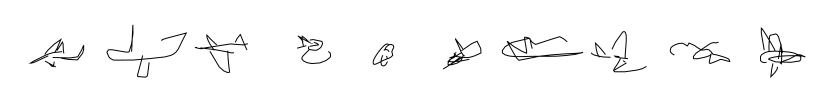

In [229]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.1, draw_mode=False), [0, i]])
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Its a bird. Its a plane. Its .... a computers doodles. It draws like me!
Lets have a look at some random sample data to see whats going on.

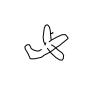

In [207]:
stroke = test_set.random_sample()
draw_strokes(stroke,factor=0.2)
# Interesting. Slight diagonal

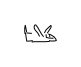

In [208]:
stroke = test_set.random_sample()
draw_strokes(stroke)
# Pretty good

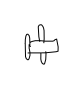

In [225]:
stroke = test_set.random_sample()
draw_strokes(stroke,factor=0.2)
# Hmm. Square plane

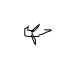

In [210]:
stroke = test_set.random_sample()
draw_strokes(stroke,factor=0.2)
# Something I would doodle

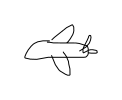

In [211]:
stroke = test_set.random_sample()
draw_strokes(stroke,factor=0.2)
# plane-ish

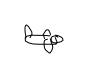

In [212]:
stroke = test_set.random_sample()
draw_strokes(stroke,factor=0.2)
# Facing right

Probable reasons my models drawings are random doodles instead of cool planes.
- My training model is on default settings. It probably needs to be tweaked a bit.
- More training time
- Aeroplanes drawn in all sorts of orientations as well. Not sure how the model would learn on that